# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Introduction to Data Science

## Lab 8: Recurrent Neural Networks and Introduction to Natural Language Processing

**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas<br/>
**Lab Leaders**: Marios Mattheakis & Chris Gumb
<br/>

## Learning Objectives

By the end of this Lab, you should understand how to:
- use `keras` for constructing a simple RNN for time-series prediction
- perform basic preprocessing on text data (stemming, tokenization, padding, one-hot encoding)
- Feed Forward NNs for NLP tasks 
- add embedding layers to improve the performance 
- use `keras` simple RNNs for NLP 
- inspect the embedding space

<a id="contents"></a>

## Notebook Contents

- [**Simple RNNs**](#rnn_intro)
    - [Time-series prediction](#timeSeries)
    - [Activity 1: Forecasting timeseries](#act1)
- [**Introduction to NLP**](#NLP_intro)
    - [Case Study: IMDB Review Dataset](#imdb)
- [**Preprocessing Text Data**](#prep)
    - [Tokenization](#token)
    - [Stemming](#stem)
    - [Padding](#pad)
    - [Numerical Encoding](#encode)    
- [**Neural Networks for NLP**](#NN)
    - [Feed Forward Neural Networks](#FFNN)
    - [Embedding layer](#embedding)    
    - [Activity 2: Recurrent Neural Networks with embeddings](#act2)
- [**Extra Material: Inspecting the embedding space**](#SM)


In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Flatten #GRU, LSTM
from sklearn.model_selection import train_test_split
import tensorflow_datasets
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# fix random seed for reproducibility
np.random.seed(109)

import warnings
warnings.filterwarnings('ignore')

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Simple Recurrent Neural Networks (RNNs) <div id='rnn_intro'>



An RNN is similar to a FFNN in that there is an input layer, a hidden layer, and an output layer. The input layer is fully connected to the hidden layer, and the hidden layer is fully connected to the output layer. However, the crux of what makes it a **recurrent** neural network is that the hidden layer for a given time _t_ is not only based on the input layer at time _t_ but also the hidden layer from time _t-1_.

Here's a popular blog post on [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).


In Keras, the vanilla RNN unit is implemented the`SimpleRNN` layer:
```
tf.keras.layers.SimpleRNN(
    units, activation='tanh', use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
    dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False,
    go_backwards=False, stateful=False, unroll=False, **kwargs
)
```
For more details check Keras' documention https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN.

As you can see, recurrent layers in Keras take many arguments. We only need to be concerned with `units`, which specifies the size of the hidden state. 

**REMOVE**, and `return_sequences`, which will be discussed shortly. For the moment is it fine to leave this set to the default of `False`.

As you will see next week simple RNNs have some serious problems and limitations, like the gradient vanishing/exploding issue.  Due to these limitations, simple RNN unit  tends not to be used much in practice. For this reason it seems that the Keras developers neglected to implement GPU acceleration for this layer! Later in the Lab, you will notice that training an RNN is slower the training an FFNN even when the RNN has fewer parameters. 
https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN

## Time-series prediction <div id = 'timeSeries'>
    
RNNs become effective in learning from sequential data like time series and text. Let's start this journey in RNNs by predicting a noisy time series. 

Generate some synthetic sequential noisy data

Text(0, 0.5, 'Series')

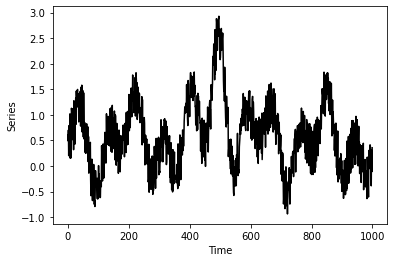

In [2]:
N =  1000    
Tp = 800    

t=np.arange(0,N)

x=np.sin(0.02*t)* 1*np.sin(0.05*t) + 2*np.exp(-(t-500)**2/1000)
#Add gaussian (white) noise
x += np.random.rand(N)


df = pd.DataFrame(x)


plt.plot(t, x,'k')
plt.xlabel('t'); plt.xlabel('x'); 
plt.xlabel('Time'); plt.ylabel('Series')



#### Split data into training and testing sets
Note, this is forecasting, so we do not know the future 

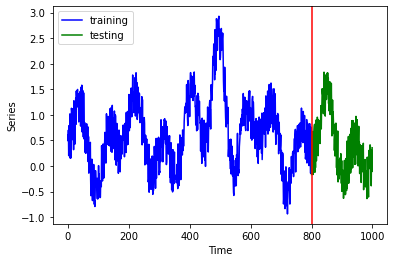

In [3]:
values=df.values
train,test = values[0:Tp,:], values[Tp:N,:]

plt.plot(df[0:Tp], 'b', label='training')
plt.plot(df[Tp:N], 'g', label='testing')

plt.axvline(df.index[Tp], c="r")
plt.xlabel('Time'); plt.ylabel('Series')
plt.legend()

#### Prepare the data

RNNs  require a step value that contains `n` number of elements as an input sequence. Here, we define it as a `step`. 
Let's understand this concept through  two simple cases. Cosidere the input `x` and the output `y`:
- For step=1: 
   - x=[1,2,3,4,5]
   - y=[2,3,4,5,6]
- For step=2: 
   - x=[ (1,2), (2,3), (3,4) (4,5) ]
   - y=[3,4,5,6]

   

The sizes of `x`  and `y` are  different. We can  fix this by adding step size into the training and test data.


In [25]:
print(train.shape, test.shape )

(900,) (300,)


In [26]:
step = 4
# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

In [27]:
print(train.shape, test.shape )

(904,) (304,)


Convert the datasets into the matrix with step value as it has shown above explation.


In [28]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

trainX, trainY =convertToMatrix(train,step)
testX,  testY =convertToMatrix(test,step)

print('Shapes of the training dataset for (x,y): ', trainX.shape, trainY.shape)
print('Shapes of the testing dataset for (x,y) : ', testX.shape, testY.shape)

Shapes of the training dataset for (x,y):  (900, 4) (900,)
Shapes of the testing dataset for (x,y) :  (300, 4) (300,)


Finally, we reshape `trainX` and `testX` to fit with the Keras RNN model that  requires three-dimensional input data.



In [29]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, testX.shape)

(900, 1, 4) (300, 1, 4)


In [30]:
model = Sequential()
# Here, we add the RNN unit. Keras makes it easy for us 
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
#
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer= 'adam' )
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 32)                1184      
                                                                 
 dense_18 (Dense)            (None, 8)                 264       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit(trainX,trainY, epochs=100, batch_size=32, verbose=0)

trainPredict = model.predict(trainX)
testPredict  = model.predict(testX)

# concate train and test predictions for plotting purposes
predicted = np.concatenate((trainPredict,testPredict),axis=0)


In [32]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
testScore = model.evaluate(testX, testY, verbose=0)
print('Train score: ', trainScore)
print('Test score: ', testScore)

Train score:  0.08799836039543152
Test score:  0.08053788542747498


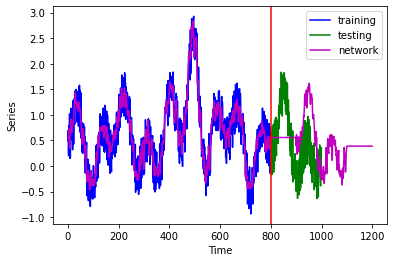

In [33]:
index = df.index.values
plt.plot(df[0:Tp], 'b', label='training')
plt.plot(df[Tp:N], 'g', label='testing')
# plt.plot(index,predicted)
plt.plot(predicted, 'm', label='network')
plt.axvline(df.index[Tp], c="r")
plt.xlabel('Time'); plt.ylabel('Series')
plt.legend()


# Activity 1 <div id='act1'></div>
- Repeat the above experiment for different steps in the range [1, 10, 100].
- Does the step affect the performance? Make some comments


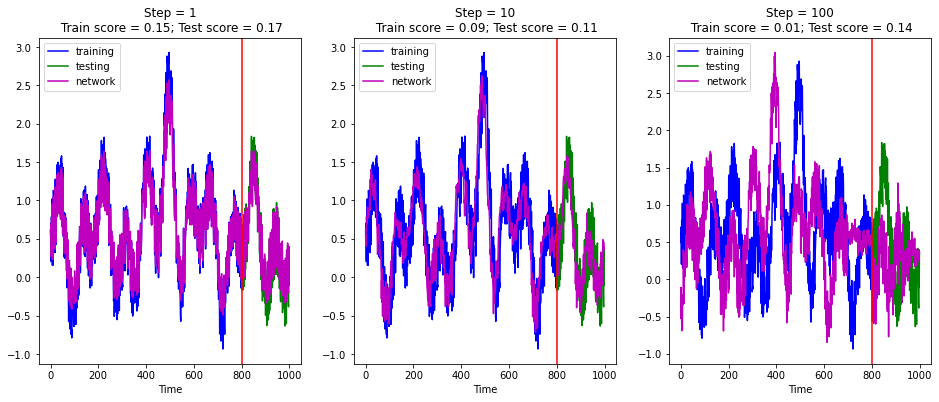

In [34]:
# you code here

plt.figure(figsize= [16,6] )

## define step range
step_range = [1,10, 100]


i=0
for step in step_range:

    ## repeat this step because we change the train/test during in the loop
    values=df.values
    train,test = values[0:Tp,:], values[Tp:N,:]


    ## add step elements into train and test
    test = np.append(test,np.repeat(test[-1,],step))
    train = np.append(train,np.repeat(train[-1,],step))


    ## Convert to matrix (used the helper function 'conertToMatrix' defined earlier )
    trainX, trainY =convertToMatrix(train,step)
    testX,  testY =convertToMatrix(test,step)

    ## reshape X sets to be 3-dimensional as RNN unit expects 
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    ## Construct the network architecture
    model = Sequential()
    model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
    model.add(Dense(8, activation="relu")) 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer= 'adam' )

    ## Evaluate the model
    model.fit(trainX,trainY, epochs=100, batch_size=32, verbose=0)
    trainPredict = model.predict(trainX)
    testPredict  = model.predict(testX)

    ## Concate train and test predictions and calculate the scores
    predicted = np.concatenate((trainPredict,testPredict),axis=0)
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    testScore = model.evaluate(testX, testY, verbose=0)

    ## make somes subpots
    ax = plt.subplot(1, 3, i + 1)
    index = df.index.values
    ax.plot(df[0:Tp], 'b', label='training')
    ax.plot(df[Tp:N], 'g', label='testing')
    ax.plot(predicted, 'm', label='network')
    ax.axvline(df.index[Tp], c="r")
    ax.set_xlabel('Time'); # plt.set_ylabel('Series')
    ax.set_title('Step = ' + str(step) + '\n Train score = '
              + str(round(trainScore,2)) + '; Test score = ' + str(round(testScore,2)))
    ax.legend()

    i+=1



# Introduction to NLP <div id = 'LP_intro'></div>
    
## Case Study: IMDB Review Classifier <div id='imdb'></div>
<!-- <img src='fig/manyto1.png' width='300px'> -->

Let's frame our introduction to NLP  around the example of a text classifier. Specifically, we'll build and evaluate various models that all attempt to descriminate between positive and negative reviews through the Internet Movie Database (IMDB). The dataset is again made available to us through the tensorflow datasets API.

In [36]:
(train, test), info = tensorflow_datasets.load('imdb_reviews', split=['train', 'test'], with_info=True)

The helpful `info` object provides details about the dataset.

In [37]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='/home/u_61397728/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <Sp

We see that the dataset consists of text reviews and binary good/bad labels. Here are two examples:

In [38]:
labels = {0: 'bad', 1: 'good'}
seen = {'bad': False, 'good': False}
for review in train:
    label = review['label'].numpy()
    if not seen[labels[label]]:
        print(f"text:\n{review['text'].numpy().decode()}\n")
        print(f"label: {labels[label]}\n")
        seen[labels[label]] = True
    if all(val == True for val in seen.values()):
        break

text:
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.

label: bad

text:
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the pl

2022-04-02 04:08:19.266008: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Preprocessing Text Data <div id='prep'></div>

Computers have no built-in knowledge of language and cannot understand text data in any rich way that humans do -- at least not without some help! The first crucial step in natural language processing is to clean and preprocess your data so that your algorithms and models can make use of it.
    
We'll look at a few preprocess steps:
- Tokenization
- Stemming 
- Padding
- Numerical encoding
        
Depending on your NLP task, you may (or may not) want to take additional preprocessing steps which we will not cover here. These can include:
- converting all characters to lowercase
- treating each punctuation mark as a token (e.g., , . ! ? are each separate tokens)
- removing punctuation altogether
- separating each sentence with a unique symbol (e.g., <S> and </S>)
- removing words that are incredibly common (e.g., function words, (in)definite articles). These are referred to as 'stopwords').
- Lemmatizing (replacing words with their 'dictionary entry form')
    
Useful NLP Python libraries such as [NLTK](https://www.nltk.org/) and [spaCy](https://spacy.io/) provide built in methods for many of these preprocessing steps.

<!-- <div class='exercise' id='token'><b>Tokenization</b></div></br> -->
## Tokenization  <div id='token'></div>

**Tokenization**   is the process of breaking a document down into words, punctuation marks, numeric digits, etc.

**Tokens** are the atomic units of meaning which our model will be working with. What should these units be? These could be characters, words, or even sentences. For our movie review classifier we will be working at the word level.

For this example we will process just a subset of the original dataset.

In [39]:
SAMPLE_SIZE = 10 # # of the reviews to be considered
subset = list(train.take(SAMPLE_SIZE))
subset[5]

2022-04-02 04:11:29.419936: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


{'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 'text': <tf.Tensor: shape=(), dtype=string, numpy=b"This is a film which should be seen by anybody interested in, effected by, or suffering from an eating disorder. It is an amazingly accurate and sensitive portrayal of bulimia in a teenage girl, its causes and its symptoms. The girl is played by one of the most brilliant young actresses working in cinema today, Alison Lohman, who was later so spectacular in 'Where the Truth Lies'. I would recommend that this film be shown in all schools, as you will never see a better on this subject. Alison Lohman is absolutely outstanding, and one marvels at her ability to convey the anguish of a girl suffering from this compulsive disorder. If barometers tell us the air pressure, Alison Lohman tells us the emotional pressure with the same degree of accuracy. Her emotional range is so precise, each scene could be measured microscopically for its gradations of trauma, on a scale of rising hyster

The TFDS format process datasets into a standard format and therefore, allows for the construction of efficient preprocessing pipelines. But for our own preprocessing example we will be primarily working with Python `list` objects. This gives us a chance to practice the Python **list comprehension** which is a powerful tool to have at your disposal. It will serve you well when processing arbitrary text which may not already be in a nice TFDS format (such as in the HW 😉).

We'll convert our data subset into X and y lists.

In [40]:
X = [x['text'].numpy().decode() for x in subset]
y = [x['label'].numpy() for x in subset]

In [41]:
print(f'X has {len(X)} reviews')
print(f'y has {len(y)} labels')

X has 10 reviews
y has 10 labels


In [43]:
N_CHARS = 20
print(f'First {N_CHARS} characters of all reviews:\n{[x[:20]+"..." for x in X]}\n')
print(f'All labels:\n{y}')

First 20 characters of all reviews:
['This was an absolute...', 'I have been known to...', 'Mann photographs the...', 'This is the kind of ...', 'As others have menti...', 'This is a film which...', 'Okay, you have:<br /...', 'The film is based on...', 'I really love the se...', "Sure, this one isn't..."]

All labels:
[0, 0, 0, 1, 1, 1, 0, 0, 0, 0]


Each observation in `X` is a review. A review is a `str` object which we can think of as a sequence of characters. This is indeed how Python treats strings as made clear by how we are printing 'slices' of each review in the code cell above.<br>

In this example, we will work  at a word level.  This means that our observations should be organized as **sequences of words** rather than sequences of characters. In general, we can prepare our data in different ways like at a character level.



In [44]:
# list comprehensions again to the rescue!
X_ = [x.split() for x in X]   # keep this temporal object for a comparison purpose, will see shortly
X = [x.split() for x in X]


Now let's look at the first 10 **tokens** in the first 2 reviews.

In [53]:
print('Review 1: ', X[0][:10])
print('Review 2: ', X[1][:10])

Review 1:  ['This', 'was', 'an', 'absolutely', 'terrible', 'movie.', "Don't", 'be', 'lured', 'in']
Review 2:  ['I', 'have', 'been', 'known', 'to', 'fall', 'asleep', 'during', 'films,', 'but']


## Stemming <div id='stem'></div>
**Stemming**  is the process of producing morphological variants of a root/base word. For example, a stemming algorithm reduces the words "chocolates", "chocolatey", "choco" to the root word, "chocolate" or the words "likes", "liked", "likely", "liking" to "like".

Stemming is desirable as it may reduce redundancy as most of the time the word stem and their inflected/derived words mean the same.

Here, we use the package **Natural Language Tool Kit (NLTK)** for more information check [here](https://www.nltk.org/api/nltk.stem.html)

In [54]:
from nltk.stem import PorterStemmer

In [55]:
# object for steamming 
ps = PorterStemmer()
# perform stemming in all the sentences
X = [[ps.stem(w) for w in x] for x in X]

Inspect the above nested list comprehension: 

```
i=0
for words in X:
    j=0
    for w in words:
        X[i][j]=ps.stem(w)
        j+=1
    i+=1
```

Let's compare the words before and after stemming

In [56]:
for i in range(20):
    print(X_[0][i], ' --> ', X[0][i])

This  -->  thi
was  -->  wa
an  -->  an
absolutely  -->  absolut
terrible  -->  terribl
movie.  -->  movie.
Don't  -->  don't
be  -->  be
lured  -->  lure
in  -->  in
by  -->  by
Christopher  -->  christoph
Walken  -->  walken
or  -->  or
Michael  -->  michael
Ironside.  -->  ironside.
Both  -->  both
are  -->  are
great  -->  great
actors,  -->  actors,


<div  style="background-color:#b3e6ff">
<b>Q</b>: Should we always use stemming?
</div>

In classification tasks (like sentiment analysis) stemming is fine. But what about in a text generation task?

## Padding <div id='pad'></div>

Let's take a look at the lengths of the reviews in our subset.

In [93]:
[len(x) for x in X]

[116, 112, 132, 88, 81, 289, 557, 111, 223, 127]

If we were training our RNN one sentence at a time, it would be okay to have sentences of varying lengths. However, as with any neural network, it can be sometimes be advantageous to train inputs in batches. When doing so with RNNs, our input tensors need to be of the same length/dimensions.

Here are two examples of tokenized reviews padded to have a length of 5.
```
['I', 'loved', 'it', '<PAD>', '<PAD>']
['It', 'stinks', '<PAD>', '<PAD>', '<PAD>']
```
Now let's pad our own examples. Note that 'padding' in this context also means truncating sequences that are longer than our specified max length.

In [57]:
MAX_LEN = 500
PAD = '<PAD>'
# truncate
X = [x[:MAX_LEN] for x in X]
# pad
for x in X:
    while len(x) < MAX_LEN:
        x.append(PAD)

In [58]:
[len(x) for x in X]

[500, 500, 500, 500, 500, 500, 500, 500, 500, 500]

Now all reviews have the same length!

## Numerical Encoding <div id='encode'></div>

If each review in our dataset is an observation, then the features of each observation are the tokens, in this case, words. But these words are still **strings**. Our machine learning methods require us to be able to multiple our features by weights. If we want to use these words as inputs for a neural network we'll have to convert them into some **numerical representation**.

One solution is to create a **one-to-one mapping** between unique words and integers.

If the five sentences below were our entire corpus, our conversion would look this:

1. i have books - [1, 4, 2]
2. interesting books are useful [11,2,9,8]
3. i have computers [1,4,3]
4. computers are interesting and useful [3,5,11,10,8]
5. books and computers are both valuable. [2,10,3,9,13,12]
6. bye bye [7,7]

I-1, books-2, computers-3, have-4, are-5, computers-6,bye-7, useful-8, are-9, and-10,interesting-11, valuable-12, both-13

To accomplish this we'll first need to know what all the unique words are in our dataset.

In [59]:
all_tokens = [word for review in X for word in review]

In [60]:
# sanity check
len(all_tokens), sum([len(x) for x in X])

(5000, 5000)

Casting our `list` of words into a `set` is a great way to get all the *unique* words in the data. Hence, we build our **vocabulary**. 

In [61]:
vocab = sorted(set(all_tokens))
print('Unique Words in our vocabulary:', len(vocab))

Unique Words in our vocabulary: 819


You can easily check that the vocabulary will be larger if stemming is not applied. Check it by yourself.

Now we need to create a mapping from words to integers. For this we will perform a **dictionary comprehension**.

In [62]:
word2idx = {word: idx for idx, word in enumerate(vocab)}

In [63]:
word2idx

{'"absolut': 0,
 '"actors"': 1,
 '"bohlen"-fan': 2,
 '"brideshead': 3,
 '"candy"?).': 4,
 '"citi': 5,
 '"dewy-eyed."<br': 6,
 '"dieter': 7,
 '"dieter"': 8,
 '"dragonfly"': 9,
 '"hey,': 10,
 '"i\'v': 11,
 '"lady."<br': 12,
 '"london': 13,
 '"make': 14,
 '"meanwhile,")': 15,
 '"men"': 16,
 '"miss"': 17,
 '"mr': 18,
 '"mrs."': 19,
 "'em": 20,
 "'round": 21,
 "'where": 22,
 '(a': 23,
 '(at': 24,
 '(backbon': 25,
 '(barbarella).': 26,
 '(brit': 27,
 '(i': 28,
 '(jeremi': 29,
 '(not': 30,
 '(rememb': 31,
 '(the': 32,
 "(there'": 33,
 '(they': 34,
 '(we': 35,
 '(what': 36,
 '(when,': 37,
 '(ye': 38,
 '(you': 39,
 '-': 40,
 '.': 41,
 '/><br': 42,
 '/>ah,': 43,
 '/>and': 44,
 '/>but': 45,
 '/>canadian': 46,
 '/>david': 47,
 '/>first': 48,
 '/>henceforth,': 49,
 '/>joanna': 50,
 '/>journalist': 51,
 '/>noth': 52,
 '/>ok,': 53,
 '/>penelop': 54,
 '/>peter': 55,
 '/>second': 56,
 '/>so': 57,
 '/>susan': 58,
 '/>thank': 59,
 '/>third': 60,
 '/>to': 61,
 '/>when': 62,
 '/>wrong!': 63,
 '1-dimension'

We repeat the process, this time mapping integers to words.

In [101]:
idx2word = {idx: word for idx, word in enumerate(vocab)}

In [102]:
idx2word

{0: '"absolut',
 1: '"actors"',
 2: '"bohlen"-fan',
 3: '"brideshead',
 4: '"candy"?).',
 5: '"citi',
 6: '"dewy-eyed."<br',
 7: '"dieter',
 8: '"dieter"',
 9: '"dragonfly"',
 10: '"hey,',
 11: '"i\'v',
 12: '"lady."<br',
 13: '"london',
 14: '"make',
 15: '"meanwhile,")',
 16: '"men"',
 17: '"miss"',
 18: '"mr',
 19: '"mrs."',
 20: "'em",
 21: "'round",
 22: "'where",
 23: '(a',
 24: '(at',
 25: '(backbon',
 26: '(barbarella).',
 27: '(brit',
 28: '(i',
 29: '(jeremi',
 30: '(not',
 31: '(rememb',
 32: '(the',
 33: "(there'",
 34: '(they',
 35: '(we',
 36: '(what',
 37: '(when,',
 38: '(ye',
 39: '(you',
 40: '-',
 41: '.',
 42: '/><br',
 43: '/>ah,',
 44: '/>and',
 45: '/>but',
 46: '/>canadian',
 47: '/>david',
 48: '/>first',
 49: '/>henceforth,',
 50: '/>joanna',
 51: '/>journalist',
 52: '/>noth',
 53: '/>ok,',
 54: '/>penelop',
 55: '/>peter',
 56: '/>second',
 57: '/>so',
 58: '/>susan',
 59: '/>thank',
 60: '/>third',
 61: '/>to',
 62: '/>when',
 63: '/>wrong!',
 64: '1-dimens

Now, perform the mapping to encode the observations in our subset. One more  ***nested list comprehensions***!

In [64]:
X_proc = [[word2idx[word] for word in review] for review in X]
X_proc[0][:10], X_proc[1][:10]

([727, 765, 115, 74, 711, 492, 266, 146, 449, 392],
 [386, 363, 150, 418, 737, 305, 131, 272, 317, 173])


# Neural Networks for NLP <div id='NN'></div>

`X_proc` is a list of lists but if we are going to feed it into a `keras` model we should convert both it and `y` into `numpy` arrays.

Just a reminder that `y` is the response variable: 
```
X = [x['text'].numpy().decode() for x in subset]
y = [x['label'].numpy() for x in subset]
```

In [65]:
X_proc = np.hstack(X_proc).reshape(-1, MAX_LEN)
y = np.array(y)
print(X_proc.shape, y.shape)
X_proc, y

(10, 500) (10,)


(array([[727, 765, 115, ...,  68,  68,  68],
        [386, 363, 150, ...,  68,  68,  68],
        [455, 563, 716, ...,  68,  68,  68],
        ...,
        [716, 314, 401, ...,  68,  68,  68],
        [386, 599, 444, ...,  68,  68,  68],
        [699, 727, 535, ...,  68,  68,  68]]),
 array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0]))

## Feed Forward Neural Network  <div id='NN'></div>

Now, just to show that we've successfully processed the data, we perform a test train split and feed it into an FFNN.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, stratify=y)

In [67]:
model = Sequential()

model.add(Dense(250, activation='relu',input_dim=MAX_LEN))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=2, verbose=2)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 250)               125250    
                                                                 
 dense_27 (Dense)            (None, 1)                 251       
                                                                 
Total params: 125,501
Trainable params: 125,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
4/4 - 1s - loss: 163.6862 - accuracy: 0.2500 - val_loss: 325.3483 - val_accuracy: 0.5000 - 1s/epoch - 372ms/step
Epoch 2/5
4/4 - 0s - loss: 44.2510 - accuracy: 0.8750 - val_loss: 1010.9530 - val_accuracy: 0.5000 - 21ms/epoch - 5ms/step
Epoch 3/5
4/4 - 0s - loss: 118.6631 - accuracy: 0.7500 - val_loss: 1137.9570 - val_accuracy: 0.5000 - 21ms/epoch - 5ms/step
Epoch 4/5
4/4 - 0s - loss: 65.5713 - accuracy: 0.7500 - val_loss: 72

It worked! 
Is this a good performance? 

Well,  our subset is balanced and very small. So we shouldn't get excited about this results. 
Note that  adding more layers or neurons does not improve the performance, check it by your own! <br> 

### Load more clean data
The IMDB dataset is very popular so `keras` also includes an alternative method for loading the data. This method can save us a lot of time for many reasons:
- Cleaned text with less meaningless punctuation
- Pre-tokenized and numerically encoded
- Allows us to specify maximum vocabulary size
- more ...

In [70]:
from tensorflow.keras.datasets import imdb

# We want to have a finite vocabulary to make sure that our word matrices are not arbitrarily small
MAX_VOCAB = 10000
INDEX_FROM = 3   # word index offset 
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MAX_VOCAB, index_from=INDEX_FROM)

`get_word_index` will load a json object we can store in a dictionary. This gives us the word-to-integer mapping.

In [71]:
word2idx = imdb.get_word_index(path='imdb_word_index.json')
word2idx = {k:(v + INDEX_FROM) for k,v in word2idx.items()}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2
word2idx["<UNUSED>"] = 3
word2idx

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [72]:
idx2word = {v: k for k,v in word2idx.items()}
idx2word

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

We can see that the text data is already preprocessed for us.

In [73]:
print('Number of reviews', len(X_train))
print('Length of first and fifth review before padding', len(X_train[0]) ,len(X_train[4]),'\n')
print('First review: ', X_train[0],'\n')
print('First label: ', y_train[0],'\n')

Number of reviews 25000
Length of first and fifth review before padding 218 147 

First review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113,

Here is an example review using the index-to-word mapping we created from the loaded JSON file to view the a review in its original form.

In [74]:
def show_review(x):
    review = ' '.join([idx2word[idx] for idx in x])
    print(review)

show_review(X_train[0])

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

NOTE: This text is not comming with **padding** and **stemming**.

Looking at the distribution of lengths will help us determine what a reasonable length to pad to will be.

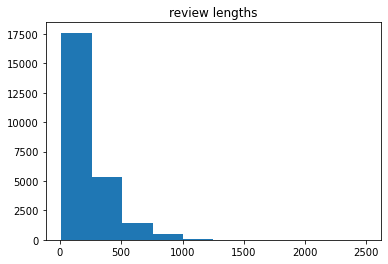

In [75]:
plt.hist([len(x) for x in X_train])
plt.title('review lengths');

We saw one way of doing this earlier, but Keras actually has a built in `pad_sequences` helper function. This handles both padding and truncating. By default padding is added to the *beginning* of a sequence.

<div class="exercise"  style="background-color:#b3e6ff">
<b>Q</b>: Why might we want to truncate? Why might we want to pad from the beginning of a sequence (sentence in this case)?
</div>

- Unless we truncate we need to pad every sentence according to the longest sentence. That will require too much padding providing a lot of useless information and long vectors which might be computationally costly. 
- Padding in the beginning of a sentence, retain the most important information in the end of sequence that sometime ehnances the performance since it keeps the 'short' memory more informative. 

In [76]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [77]:
MAX_LEN = 500
X_train = pad_sequences(X_train, maxlen=MAX_LEN, padding='pre') #padding='post' will pad in the end of a sequence
X_test = pad_sequences(X_test, maxlen=MAX_LEN, padding='pre')
print('Length of first and fifth review after padding', len(X_train[0]) ,len(X_train[4]))
print("Note that earlier the lenghts were 218 and 147.")

Length of first and fifth review after padding 500 500
Note that earlier the lenghts were 218 and 147.


In [78]:
print((X_train.shape))
X_train[0]

(25000, 500)


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Model 1: Naive Feed-Forward Network <div id='FFNN'></div>

In [82]:
model = Sequential(name='Naive_FFNN')
model.add(Dense(250, activation='relu',input_dim=MAX_LEN))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=2)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "Naive_FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 250)               125250    
                                                                 
 dense_33 (Dense)            (None, 1)                 251       
                                                                 
Total params: 125,501
Trainable params: 125,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
196/196 - 1s - loss: 174.7138 - accuracy: 0.5050 - val_loss: 88.2917 - val_accuracy: 0.5012 - 1s/epoch - 5ms/step
Epoch 2/10
196/196 - 1s - loss: 46.0150 - accuracy: 0.5872 - val_loss: 46.8252 - val_accuracy: 0.5031 - 630ms/epoch - 3ms/step
Epoch 3/10
196/196 - 1s - loss: 16.5490 - accuracy: 0.6580 - val_loss: 28.7843 - val_accuracy: 0.5030 - 635ms/epoch - 3ms/step
Epoch 4/10
196/196 - 1s - loss: 7.1110 - accuracy: 0.7207 - va

<div class="exercise"  style="background-color:#b3e6ff">
<b>Q</b>: Why was the performance so poor? How could we improve our encoding?
    
<b>A</b>: The 'magic' Embedding Layer
</div>


## Model 2: Feed-Forward Network with Embeddings <div id='embedding'></div>
<img src='wordembedding2.png' width=450px>

    
    
Embedding process is  a linear projection from one vector space to another. For NLP, we usually use embeddings to project the **sparse one-hot encodings** of words on to **a more compact lower-dimensional** continuous space.
We can view this embedding layer process as  a transformation from $\mathbb{R}^\text{inp} \rightarrow$ $\mathbb{R}^\text{emb}$

This **not only reduces dimensionality** but also **allows semantic similarities** between tokens to be captured by 'similiarities' between the embedding vectors. This was not possible with one-hot encoding as all vectors there were orthogonal to one another. 

<img src='wordembedding.png' width=450px>

It is also possible to load pretrained embeddings that were learned from giant corpora. This would be an instance of transfer learning.

If you are interested in learning more, start with the astromonically impactful papers of [word2vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) and [GloVe](https://www.aclweb.org/anthology/D14-1162.pdf).

Next **Advanced Section** will focus on  *word2vec*. 

In Keras we use the [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer:
```
tf.keras.layers.Embedding(
    input_dim, output_dim, embeddings_initializer='uniform',
    embeddings_regularizer=None, activity_regularizer=None,
    embeddings_constraint=None, mask_zero=False, input_length=None, **kwargs
)
```
We'll need to specify the `input_dim` and `output_dim`. Since we are working with sequences we  also need to set the `input_length`.

Let's implement this

In [83]:
MAX_LEN

500

In [85]:
EMBED_DIM = 2

model.reset_states()

model = Sequential(name='embedding_FFNN')
## EMBEDDING AND FLATTEN LAYERs  
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN))
model.add(Flatten())
#-
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=2)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "embedding_FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 2)            20000     
                                                                 
 flatten_2 (Flatten)         (None, 1000)              0         
                                                                 
 dense_36 (Dense)            (None, 250)               250250    
                                                                 
 dense_37 (Dense)            (None, 1)                 251       
                                                                 
Total params: 270,501
Trainable params: 270,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
196/196 - 1s - loss: 0.5359 - accuracy: 0.6989 - val_loss: 0.3091 - val_accuracy: 0.8685 - 1s/epoch - 7ms/step
Epoch 2/10
196/196 - 1s - loss: 0.2380 - accuracy: 

WoW! Notice the huge improvement in the performance. Embedding layer really helps! 

NOTE: We need a flatten layer to correct the dimensions. The embedding layer returns a matrix where each column corresponds to a word encoding. However, the next `Dense` layer is expecting a vector instead of a matrix

# Activity 2: RNN with embedding for NLP <div id='act2'></div>

<img src='simplernn.png' width=300px>


- Construct a network architecture with: 
    - an embedding layer
    - SimpleRNN unit of 250 neurons
    - Dense layer 
- Train this network on the data used in the previous example, namely `X_train`, `y_train`
    - Train for 3 epochs and for a batch_size=128. It is slow because it is not run on GPUs.
- Accordingly, evaluate on `X_test`, `y_test` datasets
- Report the accuracy score on the testing set
- Can you see any improvement comparing to the FFNN model? Make some comments


In [128]:
# Your code here

model = Sequential(name='SimpleRNN')
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN))
                # model.add(tf.keras.layers.GRU(250)) # FOR GRU implementation
model.add(SimpleRNN(250))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
#           validation_split=0.2, 
          epochs=3, batch_size=128)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "SimpleRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 2)            20000     
                                                                 
 simple_rnn_45 (SimpleRNN)   (None, 250)               63250     
                                                                 
 dense_96 (Dense)            (None, 1)                 251       
                                                                 
Total params: 83,501
Trainable params: 83,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
196/196 [==============================] - 88s 445ms/step - loss: 0.7074 - accuracy: 0.5012 - val_loss: 0.7003 - val_accuracy: 0.5000
Epoch 2/3
196/196 [==============================] - 87s 443ms/step - loss: 0.6955 - accuracy: 0.5030 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 3/3
196/196 [=====

Notice that we do not get any improvement comparing to FFNNs. What is going on here??? Why does FFNN perform better that RNNs? 

It is because this task is extremely easy and the network does not  really need memory to make a good prediction. Just some key words appearing in the text like "terrible" or "amazing" can determine the prediction. 

In more challenging tasks, like mult-categorical classification and text generation,  memory is crucial and  recurrency is a way to make it. 


Next week you will see some more efficient RNN architectures like **LSTM** and **GRU**. These are much more efficient RNNs and can also be implemented on GPUs. 

# Extra Material <div id='SM'></div>


## Inpsecting the embedding space


Let's train again the FFNN with the embeddings layer

In [86]:
EMBED_DIM = 2

model.reset_states()

model = Sequential(name='embedding_FFNN')
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "embedding_FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 2)            20000     
                                                                 
 flatten_3 (Flatten)         (None, 1000)              0         
                                                                 
 dense_38 (Dense)            (None, 250)               250250    
                                                                 
 dense_39 (Dense)            (None, 1)                 251       
                                                                 
Total params: 270,501
Trainable params: 270,501
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 85.40%


#### Get access to the embeddings or embedding space or latent space

In [87]:
from tensorflow.keras import backend

In [88]:
# with a Sequential model
get_embed_out = backend.function(
    [model.layers[0].input],
    [model.layers[1].output])

In [89]:
layer_output = get_embed_out([X_test[0]])
# layer_output = get_embed_out([X_train[0]])

print(type(layer_output), len(layer_output), layer_output[0].shape)

<class 'list'> 1 (500, 2)


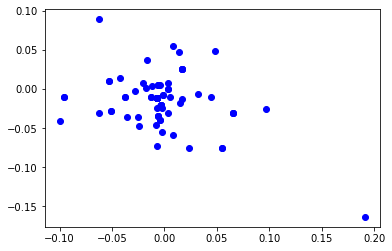

In [164]:
words = layer_output[0]
plt.plot(words[:,0], words[:,1],'bo')

#### Create a list of some representative words and check where they live in the embedding space. 
Can you see any meaningful patern? 

In [169]:
review = ['great',   'pleasure', 'good', 'awesome',
          'movie', 'and', 'was' ,
          'bad', 'boring' , 'crap']

enc_review = tf.constant([word2idx[word] for word in review])
enc_review


<tf.Tensor: shape=(10,), dtype=int32, numpy=
array([  87, 1742,   52, 1190,   20,    5,   16,   78,  357,  595],
      dtype=int32)>

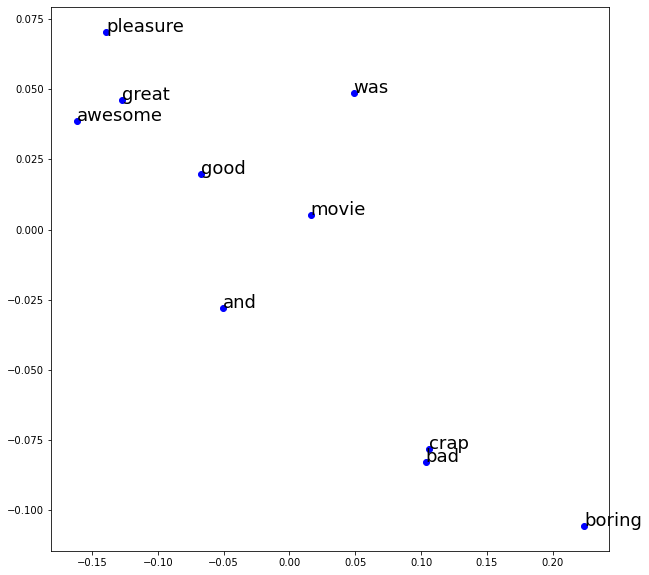

In [170]:

words = get_embed_out([enc_review])[0]

plt.figure(figsize=[10,10])
plt.plot(words[:,0], words[:,1], 'ob')
for i, txt in enumerate(review):
    plt.annotate(txt, (words[i,0], words[i,1]),  size=18)
